In [1]:
from threeML import *

from hawc_data_reader.HAWCpyLike import HAWCpyLike
from hawc_data_reader import region_of_interest

import os

os.environ['OMP_NUM_THREADS'] = "1"

%matplotlib notebook

Configuration read from /home/giacomov/.threeML/threeML_config.yml
Plotter is MatPlotlib


In [2]:
ra_crab, dec_crab = 83.633083, 22.014500

roi = region_of_interest.HealpixConeROI(3.0, 8.0, ra=ra_crab, dec=dec_crab)

hawc = HAWCpyLike("HAWC", 
                  "/home/giacomov/science/hawc/data/maptree_1024.root", 
                  "/home/giacomov/science/hawc/data/response.root",
                  roi,
                  0.17)

hawc.set_active_measurements(1, 9)

hawc.display()

Creating singleton for /home/giacomov/science/hawc/data/response.root
Using PSF from Dec Bin 57 for source HAWC
Region of Interest: 
--------------------

HealpixConeROI: Center (R.A., Dec) = (83.633, 22.015), data radius = 3.000 deg, model radius: 8.000 deg

Flat sky projection: 
----------------------

Width x height: 96 x 96 px
Pixel sizes: 0.17 deg

Response: 
----------

Response file: /home/giacomov/science/hawc/data/response.root
Number of dec bins: 106
Number of energy/nHit planes per dec bin_name: 10

Map Tree: 
----------



,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,964234222.0,9.640280e+08,1.000214,8627,28.28354
1,1,1024,RING,63464148.0,6.338158e+07,1.001303,8627,28.28354
2,2,1024,RING,20357059.0,2.029720e+07,1.002949,8627,28.28354
3,3,1024,RING,5589697.0,5.554641e+06,1.006311,8627,28.28354
4,4,1024,RING,719476.0,7.072707e+05,1.017257,8627,28.28354
5,5,1024,RING,162229.0,1.559630e+05,1.040176,8627,28.28354
6,6,1024,RING,30084.0,2.797803e+04,1.075272,8627,28.28354
7,7,1024,RING,17787.0,1.656240e+04,1.073938,8627,28.28354
8,8,1024,RING,4909.0,4.454568e+03,1.102015,8627,28.28354
9,9,1024,RING,6607.0,6.144495e+03,1.075271,8627,28.28354


This Map Tree contains 1017.288 transits
Total data size: 1.38 Mb

Active energy/nHit planes: 
---------------------------

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
spectrum = Log_parabola()

source = PointSource("CrabNebula", ra=ra_crab, dec=dec_crab, spectral_shape=spectrum)

# NOTE: if you use units, you have to set up the values for the parameters
# AFTER you create the source, because during creation the function Log_parabola
# gets its units

source.position.ra.bounds = (ra_crab - 0.5, ra_crab + 0.5)
source.position.dec.bounds = (dec_crab - 0.5, dec_crab + 0.5)

spectrum.piv = 10 * u.TeV  # Pivot energy
spectrum.piv.fix = True

spectrum.K = 1e-14 / (u.TeV * u.cm**2 * u.s)  # norm (in 1/(keV cm2 s))
spectrum.K.bounds = (1e-25, 1e-19) # without units energies are in keV

spectrum.beta = 0  # log parabolic beta
spectrum.beta.bounds = (-4., 2.)

spectrum.alpha = -2.5  # log parabolic alpha (index)
spectrum.alpha.bounds = (-4., 2.)

model = Model(source)

data = DataList(hawc)

In [4]:
jl = JointLikelihood(model, data, verbose=False)

In [5]:
jl.set_minimizer("minuit")
#%lprun -f FlatSkyToHealpixTransform.__call__ 
#%lprun -f hawc.get_log_like _ = jl.fit(quiet=False)

%prun _ = jl.fit()

# 12 s

# CrabNebula.spectrum.main.Log_parabola.K	(9.910 +/- 0.17) x 10^-23	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.793 +/- 0.018	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.550 +/- 0.11) x 10^-1

Best fit values:



,result,unit
parameter,,
CrabNebula.spectrum.main.Log_parabola.K,(1.052 +/- 0.017) x 10^-22,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.798 +/- 0.019,
CrabNebula.spectrum.main.Log_parabola.beta,(1.740 +/- 0.12) x 10^-1,



Correlation matrix:



1.00,-0.16,0.66
-0.16,1.00,-0.77
0.66,-0.77,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,19578.844885
total,19578.844885



Values of statistical measures:



,statistical measures
AIC,39163.690048
BIC,39191.785481


In [6]:
gf = GoodnessOfFit(jl)

In [7]:
gof, param, likes = gf.by_mc(10000)

OrderedDict([('total', 0.0), ('HAWC', 0.0)])


<IPython.core.display.Javascript object>


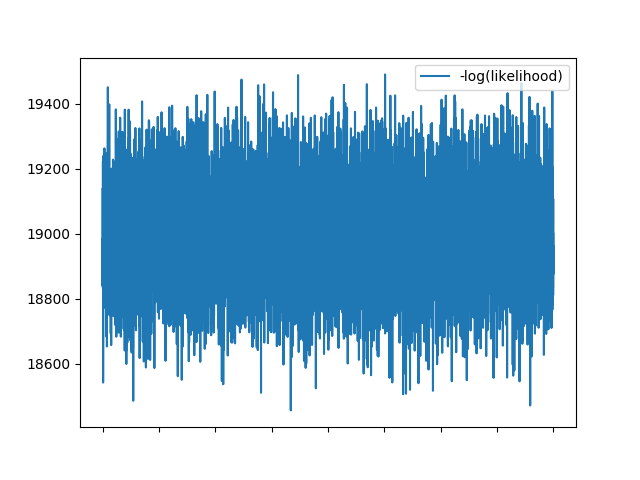

In [8]:
print(gof)
likes.plot()

<IPython.core.display.Javascript object>


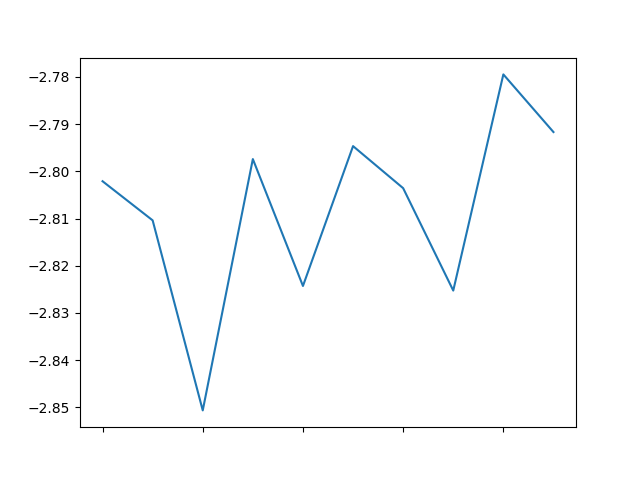

In [8]:
# (slice('A1','A3'), slice(None), ['C1', 'C3']), :

param.loc[(slice(None), ['CrabNebula.spectrum.main.Log_parabola.alpha']), 'value'].plot()

In [10]:
source.position.ra.free = True
source.position.dec.free = True

jl.set_minimizer("ROOT")

best_fit, like_frame = jl.fit()

# CrabNebula.position.ra	(8.362 +/- 0.00026) x 10	deg
# CrabNebula.position.dec	(2.202 +/- 0.00024) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(9.970 +/- 0.17) x 10^-23	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.798 +/- 0.021	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.590 +/- 0.13) x 10^-1

Best fit values:



,result,unit
parameter,,
CrabNebula.position.ra,(8.362 +/- 0.00025) x 10,deg
CrabNebula.position.dec,(2.202 +/- 0.00024) x 10,deg
CrabNebula.spectrum.main.Log_parabola.K,(9.930 +/- 0.17) x 10^-23,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.789 +/- 0.017,
CrabNebula.spectrum.main.Log_parabola.beta,(1.570 +/- 0.10) x 10^-1,



Correlation matrix:



1.00,0.07,-0.01,0.00,-0.01
0.07,1.00,-0.00,0.01,-0.00
-0.01,-0.00,1.00,-0.02,0.64
0.00,0.01,-0.02,1.00,-0.67
-0.01,-0.00,0.64,-0.67,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,237928.738305
total,237928.738305



Values of statistical measures:



,statistical measures
AIC,475867.477306
BIC,475914.302797


In [ ]:
_ = jl.get_errors()

# CrabNebula.position.ra	(8.36201 -0.00027 +0.00026) x 10	deg
# CrabNebula.position.dec	(2.20206 -0.00025 +0.00023) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(1.010 +/- 0.017) x 10^-22	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.797 +/- 0.019	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.630 +/- 0.11) x 10^-1

Starting ipyparallel cluster with this command line:
/home/giacomov/work_env/bin/ipcluster start
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json



WARNING RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@xps15')
            or instruct your controller to listen on an external IP.



8 engines are active



WARNING RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@xps15')
            or instruct your controller to listen on an external IP.



Found 8 engines


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


<IPython.core.display.Javascript object>


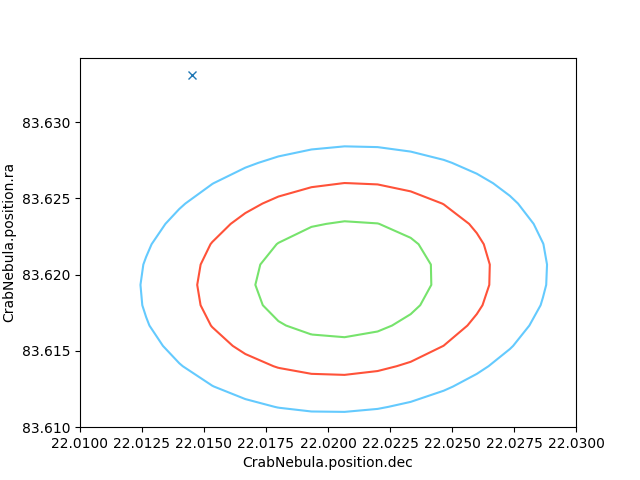


Shutting down ipcluster...


In [11]:
with parallel_computation():

    _ = jl.get_contours(model.CrabNebula.position.ra, 83.610, 83.630, 16, 
                        model.CrabNebula.position.dec, 22.010, 22.030, 16)

import matplotlib.pyplot as plt

plt.plot([dec_crab], [ra_crab], 'x')

# Parallel: 183.5

# 225 / 225 in 249.2 s (0:00:00 remaining)

In [12]:
print spectrum(1.0 * u.TeV).to(1/(u.TeV * u.cm**2 * u.s))

2.64967617321e-11 1 / (cm2 s TeV)


In [22]:
source.position.ra = ra_crab
source.position.ra.free = False

source.position.dec = dec_crab
source.position.dec.free = False

for parameter in model.parameters.values():
    
    if parameter.fix:
        
        continue
    
    if parameter.is_normalization:
    
        parameter.set_uninformative_prior(Log_uniform_prior)
    
    else:
        
        parameter.set_uninformative_prior(Uniform_prior)

bs = BayesianAnalysis(model, data)

samples = bs.sample(30, 100, 100)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Mean acceptance fraction: 0.6566666666666666

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
CrabNebula.spectrum.main.Log_parabola.K,(9.90 -0.17 +0.16) x 10^-23,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.792 +/- 0.019,
CrabNebula.spectrum.main.Log_parabola.beta,(1.580 +/- 0.12) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
HAWC,-237924.979819
total,-237924.979819



Values of statistical measures:



,statistical measures
AIC,475855.959917
BIC,475884.055350
DIC,475855.506757
PDIC,2.742970


<IPython.core.display.Javascript object>


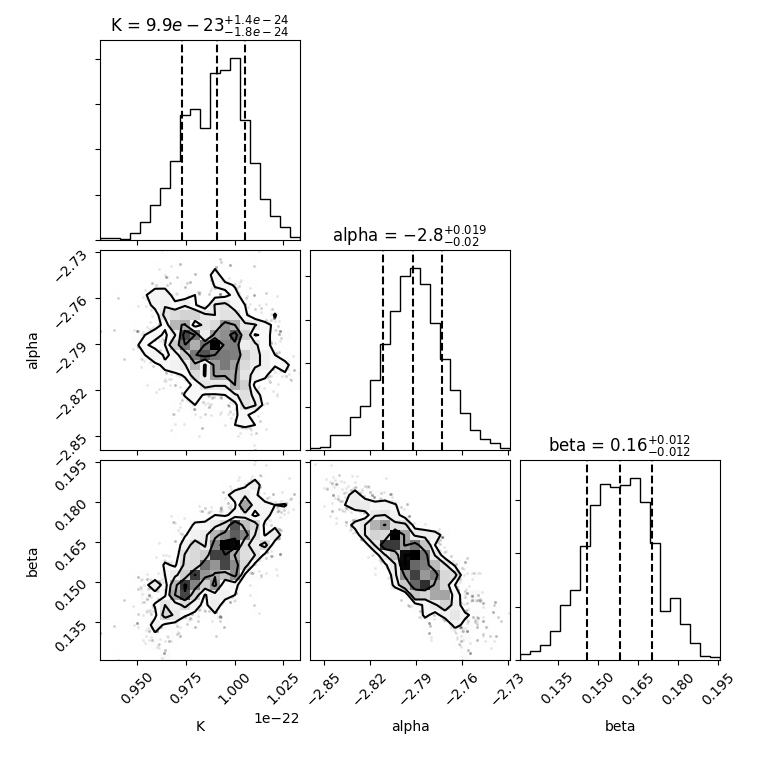

In [26]:
_ = bs.corner_plot()